# 사전 설정 (colab)

In [ ]:
# Google Drive를 Colab 환경에 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 작업 디렉토리를 헬스케어 해커톤 모델 폴더로 변경
%cd /content/drive/MyDrive/02.git/healthcare-hackathon/model

/content/drive/MyDrive/02.git/healthcare-hackathon/model


In [ ]:
import torch  # PyTorch 딥러닝 프레임워크
from PIL import Image  # PIL(Python Imaging Library) - 이미지 처리를 위한 라이브러리

- test video download link: https://drive.google.com/file/d/1PTK0s1d8wh4D-346cD3APsF9p0dMQMhl/view?usp=sharing

In [ ]:
# Google Drive에서 테스트 비디오 파일 다운로드
file_id = '1PTK0s1d8wh4D-346cD3APsF9p0dMQMhl'  # Google Drive 파일 ID
!gdown {file_id} -O /content/test_vid.mp4  # gdown을 사용하여 비디오 다운로드

Downloading...
From: https://drive.google.com/uc?id=1PTK0s1d8wh4D-346cD3APsF9p0dMQMhl
To: /content/test_vid.mp4
100% 4.44M/4.44M [00:00<00:00, 32.3MB/s]


In [ ]:
# OpenCV를 사용한 비디오 파일 정보 추출
import cv2
test_vid = '/content/test_vid.mp4'  # 테스트 비디오 파일 경로
cap = cv2.VideoCapture(test_vid)  # 비디오 캡처 객체 생성

# 비디오 속성 정보 가져오기
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))   # 비디오 너비
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) # 비디오 높이
total_frame = cap.get(cv2.CAP_PROP_FRAME_COUNT)  # 총 프레임 수

# 비디오 정보 출력
print('width, height:',width, height)
print('total_frame:',total_frame)

width, height: 480 854
total_frame: 1668.0


# MediaPipe로 faceDetect

In [ ]:
# 바운딩 박스만 그리는 함수
def draw_bounding_box(image, detection):
    # 바운딩 박스 정보 추출
    bbox = detection.location_data.relative_bounding_box
    h, w, _ = image.shape
    xmin = int(bbox.xmin * w)
    ymin = int(bbox.ymin * h)
    box_width = int(bbox.width * w)
    box_height = int(bbox.height * h)

    # 바운딩 박스 그리기
    cv2.rectangle(image, (xmin, ymin), (xmin + box_width, ymin + box_height), (0, 255, 0), 2)

In [ ]:
import cv2
import mediapipe as mp
import time

# 미디어파이프 얼굴 감지 모듈 초기화
mp_face_detection = mp.solutions.face_detection
mp_drawing = mp.solutions.drawing_utils

# 비디오 캡처 열기
cap = cv2.VideoCapture(test_vid)

# 결과를 저장할 리스트
time_st = time.time()
result = []
frame_count = 0

# 얼굴 감지 모델 생성
with mp_face_detection.FaceDetection(min_detection_confidence=0.5) as face_detection:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % 100 == 0:
            # BGR 이미지를 RGB로 변환
            image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # 얼굴 감지 수행
            results = face_detection.process(image_rgb)

            # 원본 BGR 이미지 사용
            image_bgr = frame.copy()

            # 감지된 얼굴에 바운딩 박스만 그리기
            if results.detections:
                for detection in results.detections:
                    draw_bounding_box(image_bgr, detection)

            # 감지된 이미지를 result 리스트에 추가
            result.append(image_bgr)

        frame_count += 1

# 비디오 캡처 해제
cap.release()
time_end = time.time()
runtime = time_end-time_st
print(f'실행시간 {runtime:.2f}sec')

실행시간 2.09sec


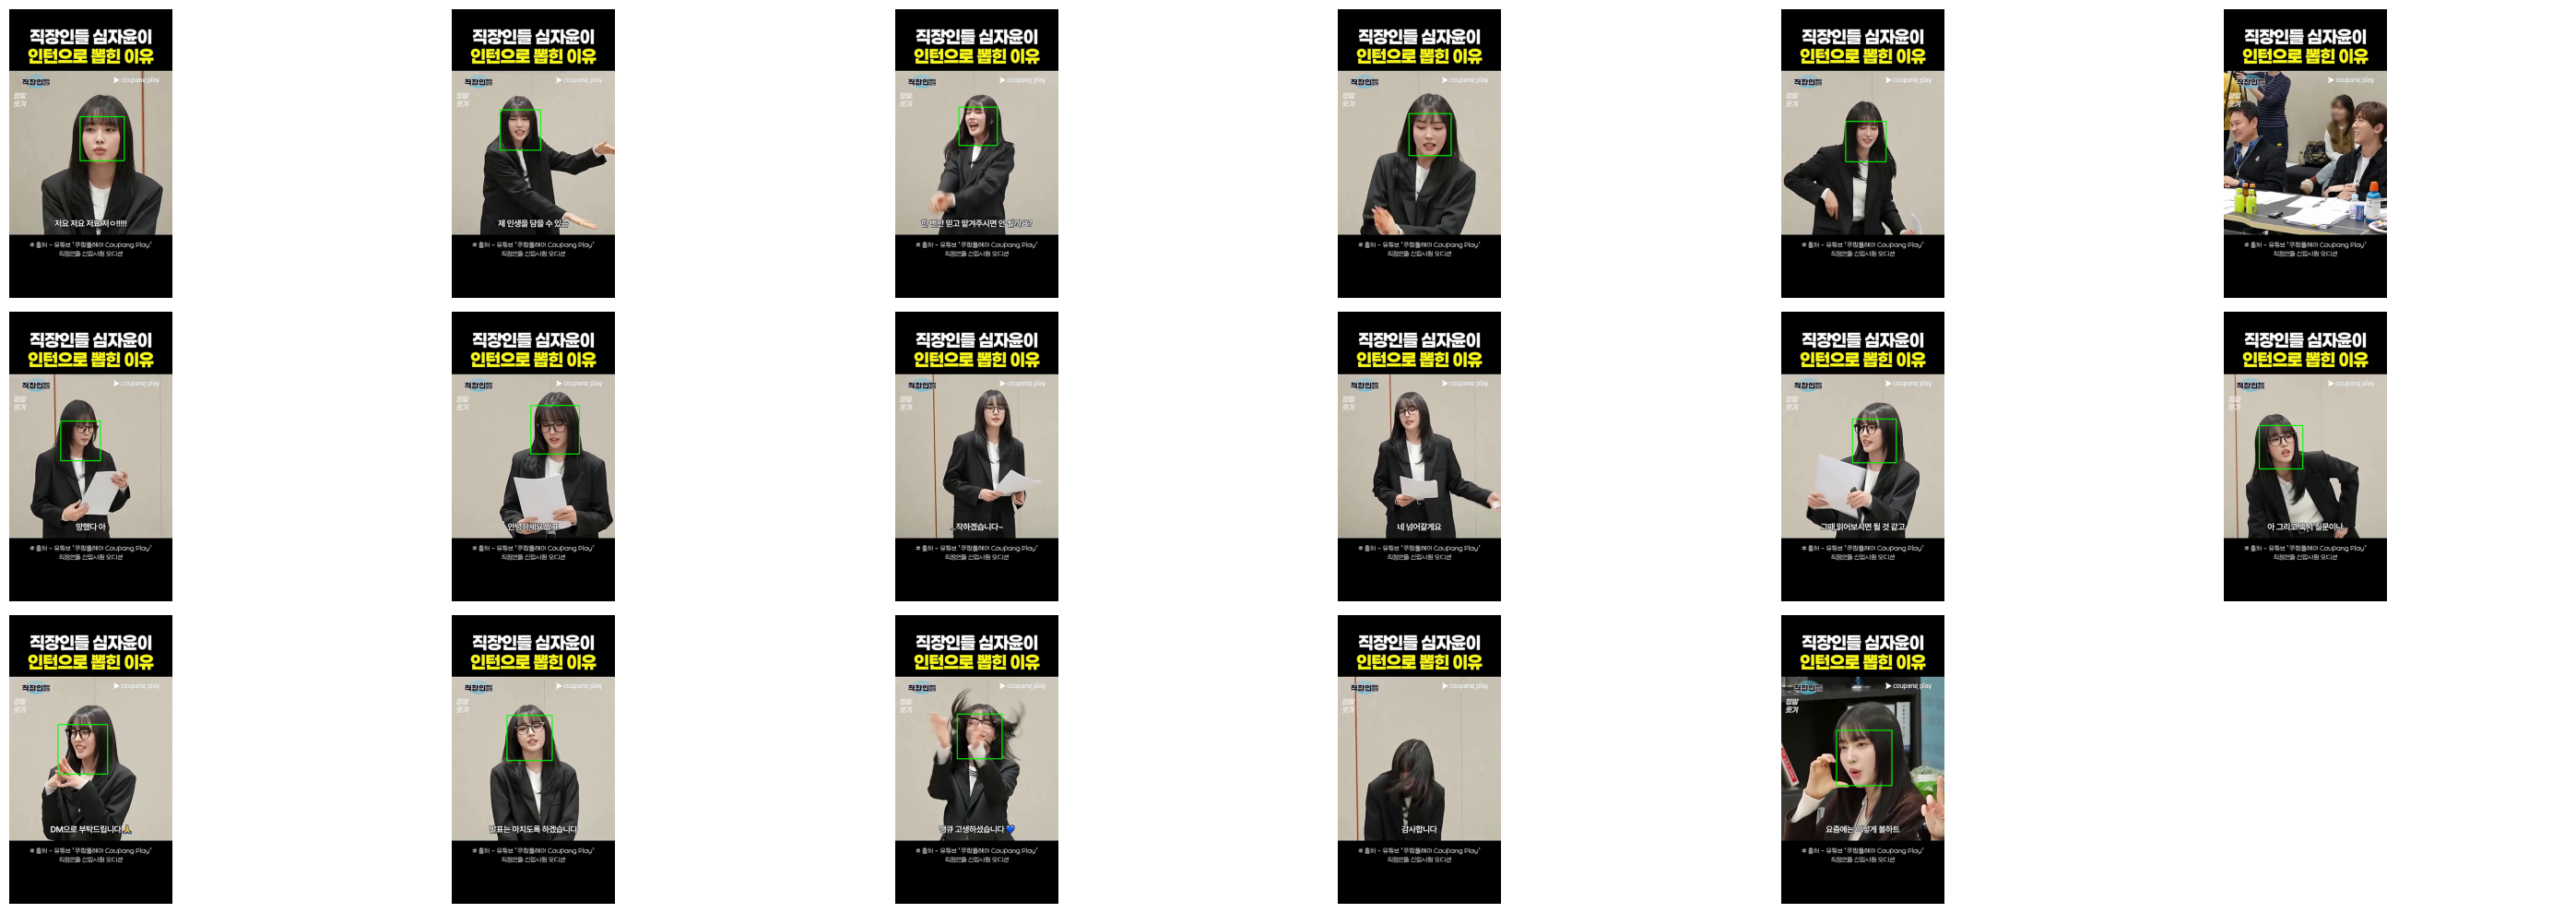

In [ ]:
import matplotlib.pyplot as plt

# 2행 6열 서브플롯 생성
fig, axes = plt.subplots(3, 6, figsize=(30, 10))

# result 리스트의 이미지를 서브플롯에 표시
for i, ax in enumerate(axes.flat):
    if i < len(result):
        ax.imshow(cv2.cvtColor(result[i], cv2.COLOR_BGR2RGB))  # BGR을 RGB로 변환
    ax.axis('off')  # 축 숨기기

plt.tight_layout()
plt.show()

# MTCNN으로 faceDetect

In [ ]:
!pip install -q mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.1 MB/s eta 0:00:00


In [ ]:
import cv2
import time
from mtcnn import MTCNN

# 비디오 캡처 열기
cap = cv2.VideoCapture(test_vid)  # 비디오 파일 경로

# 결과를 저장할 리스트
time_st = time.time()
result = []
frame_count = 0

# MTCNN 모델 초기화
detector = MTCNN()

# 얼굴 탐지 및 분석
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if frame_count % 100 == 0:
        # MTCNN을 사용하여 얼굴 탐지
        faces = detector.detect_faces(frame)

        for face in faces:
            x, y, w, h = face['box']
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # 감지된 이미지를 result 리스트에 추가
        result.append(frame)

    frame_count += 1

# 비디오 캡처 해제
cap.release()
time_end = time.time()
runtime = time_end - time_st
print(f'실행시간 {runtime:.2f}sec')

실행시간 6.65sec


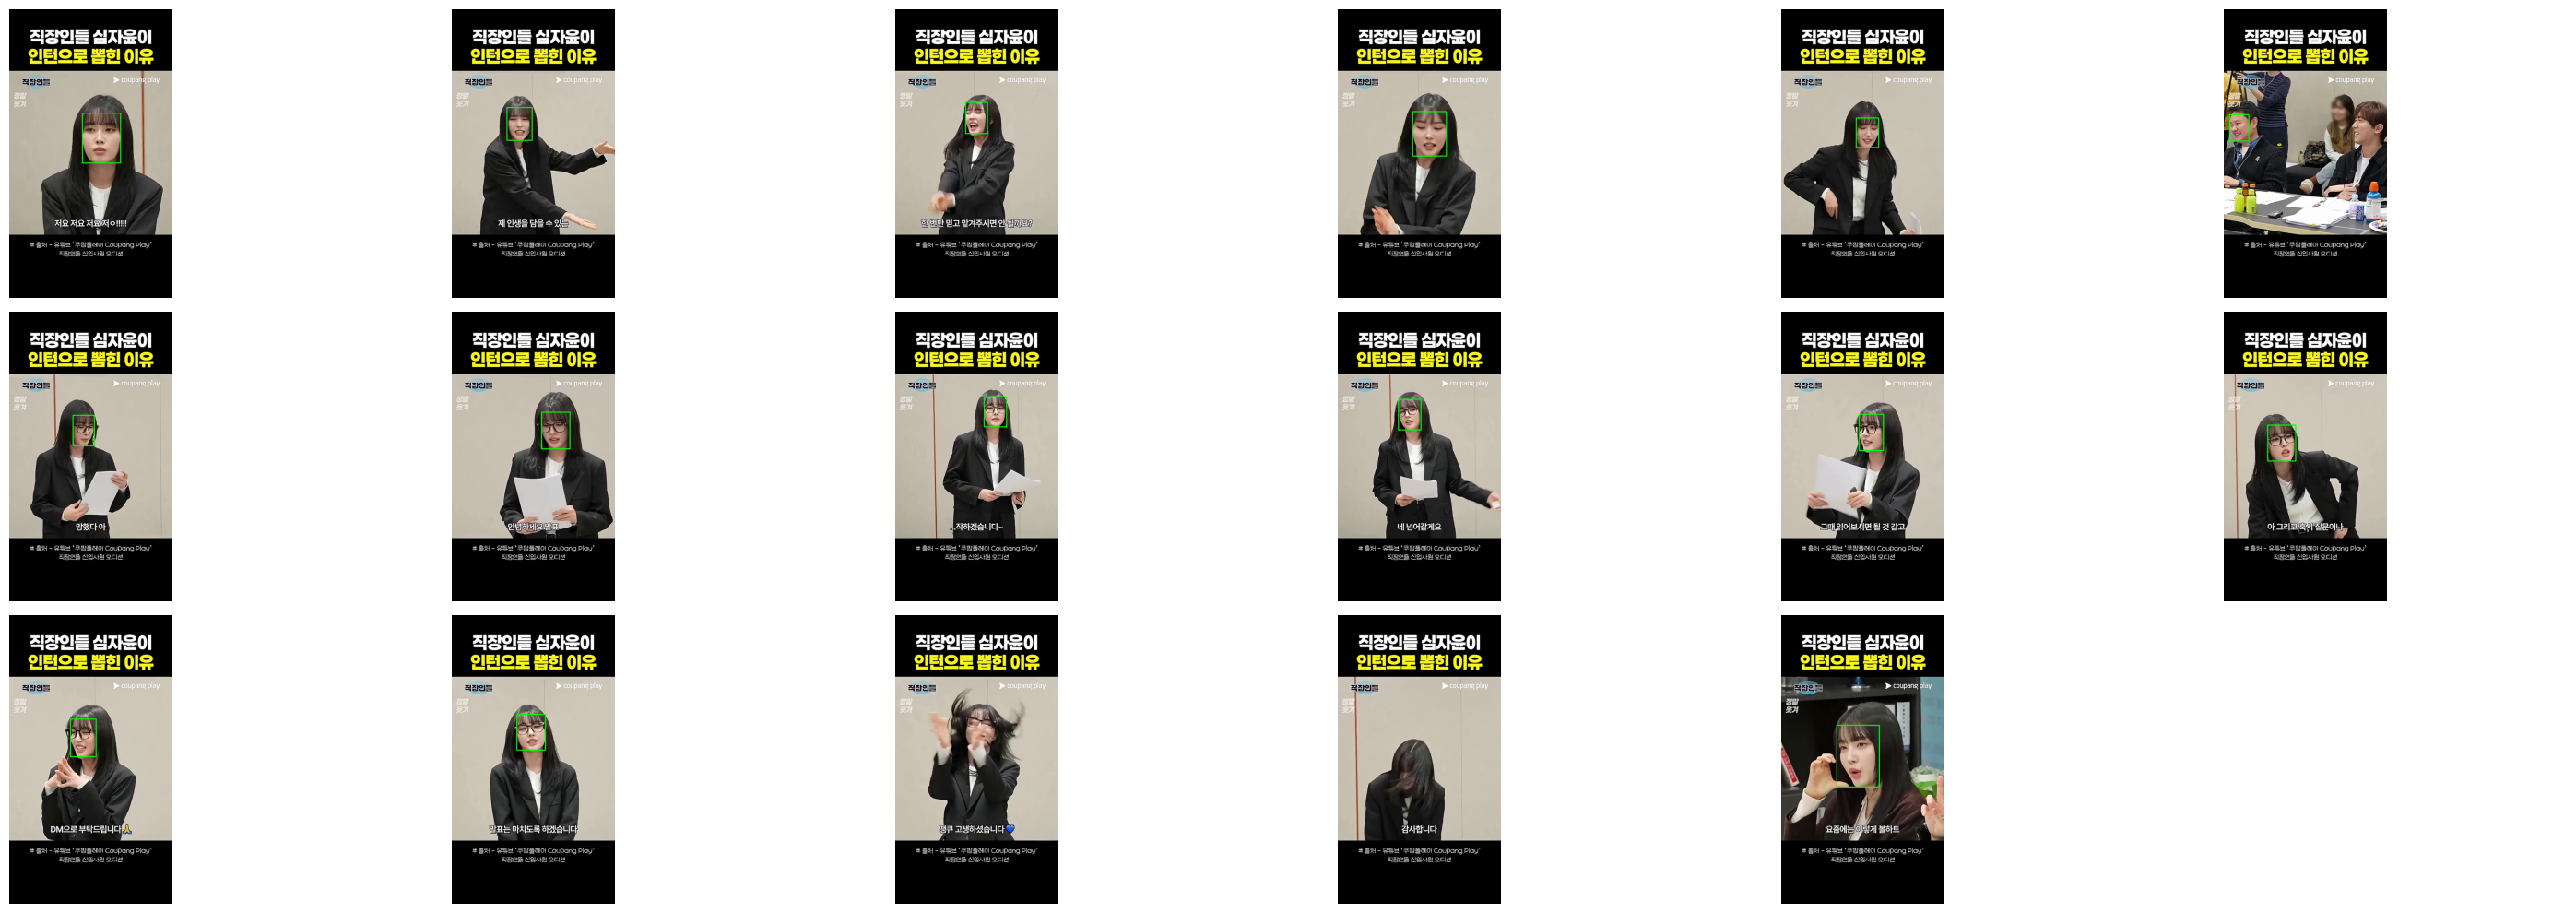

In [ ]:
import matplotlib.pyplot as plt

# 2행 6열 서브플롯 생성
fig, axes = plt.subplots(3, 6, figsize=(30, 10))

# result 리스트의 이미지를 서브플롯에 표시
for i, ax in enumerate(axes.flat):
    if i < len(result):
        ax.imshow(cv2.cvtColor(result[i], cv2.COLOR_BGR2RGB))  # BGR을 RGB로 변환
    ax.axis('off')  # 축 숨기기

plt.tight_layout()
plt.show()

# RetinaFace으로 faceDetect

In [ ]:
   !pip install -q torch torchvision
   !pip install -q retina-face

In [ ]:
import cv2
import time
from retinaface import RetinaFace

# 비디오 캡처 열기
cap = cv2.VideoCapture(test_vid)  # 비디오 파일 경로

# 결과를 저장할 리스트
time_st = time.time()
result = []
frame_count = 0

# 얼굴 탐지 및 분석
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if frame_count % 100 == 0:
        # RetinaFace를 사용하여 얼굴 탐지
        faces = RetinaFace.detect_faces(frame)

        # 감지된 얼굴에 바운딩 박스 그리기
        if isinstance(faces, dict):  # 얼굴이 탐지된 경우
            for face_id, face_info in faces.items():
                x, y, w, h = face_info['facial_area']
                cv2.rectangle(frame, (x, y), (w, h), (0, 255, 0), 2)

            # 감지된 이미지를 result 리스트에 추가
            result.append(frame)
        else:  # 얼굴이 탐지되지 않은 경우
            print(f"No face detected in frame {frame_count}")

    frame_count += 1

# 비디오 캡처 해제
cap.release()
time_end = time.time()
runtime = time_end - time_st
print(f'실행시간 {runtime:.2f}sec')

실행시간 6.01sec


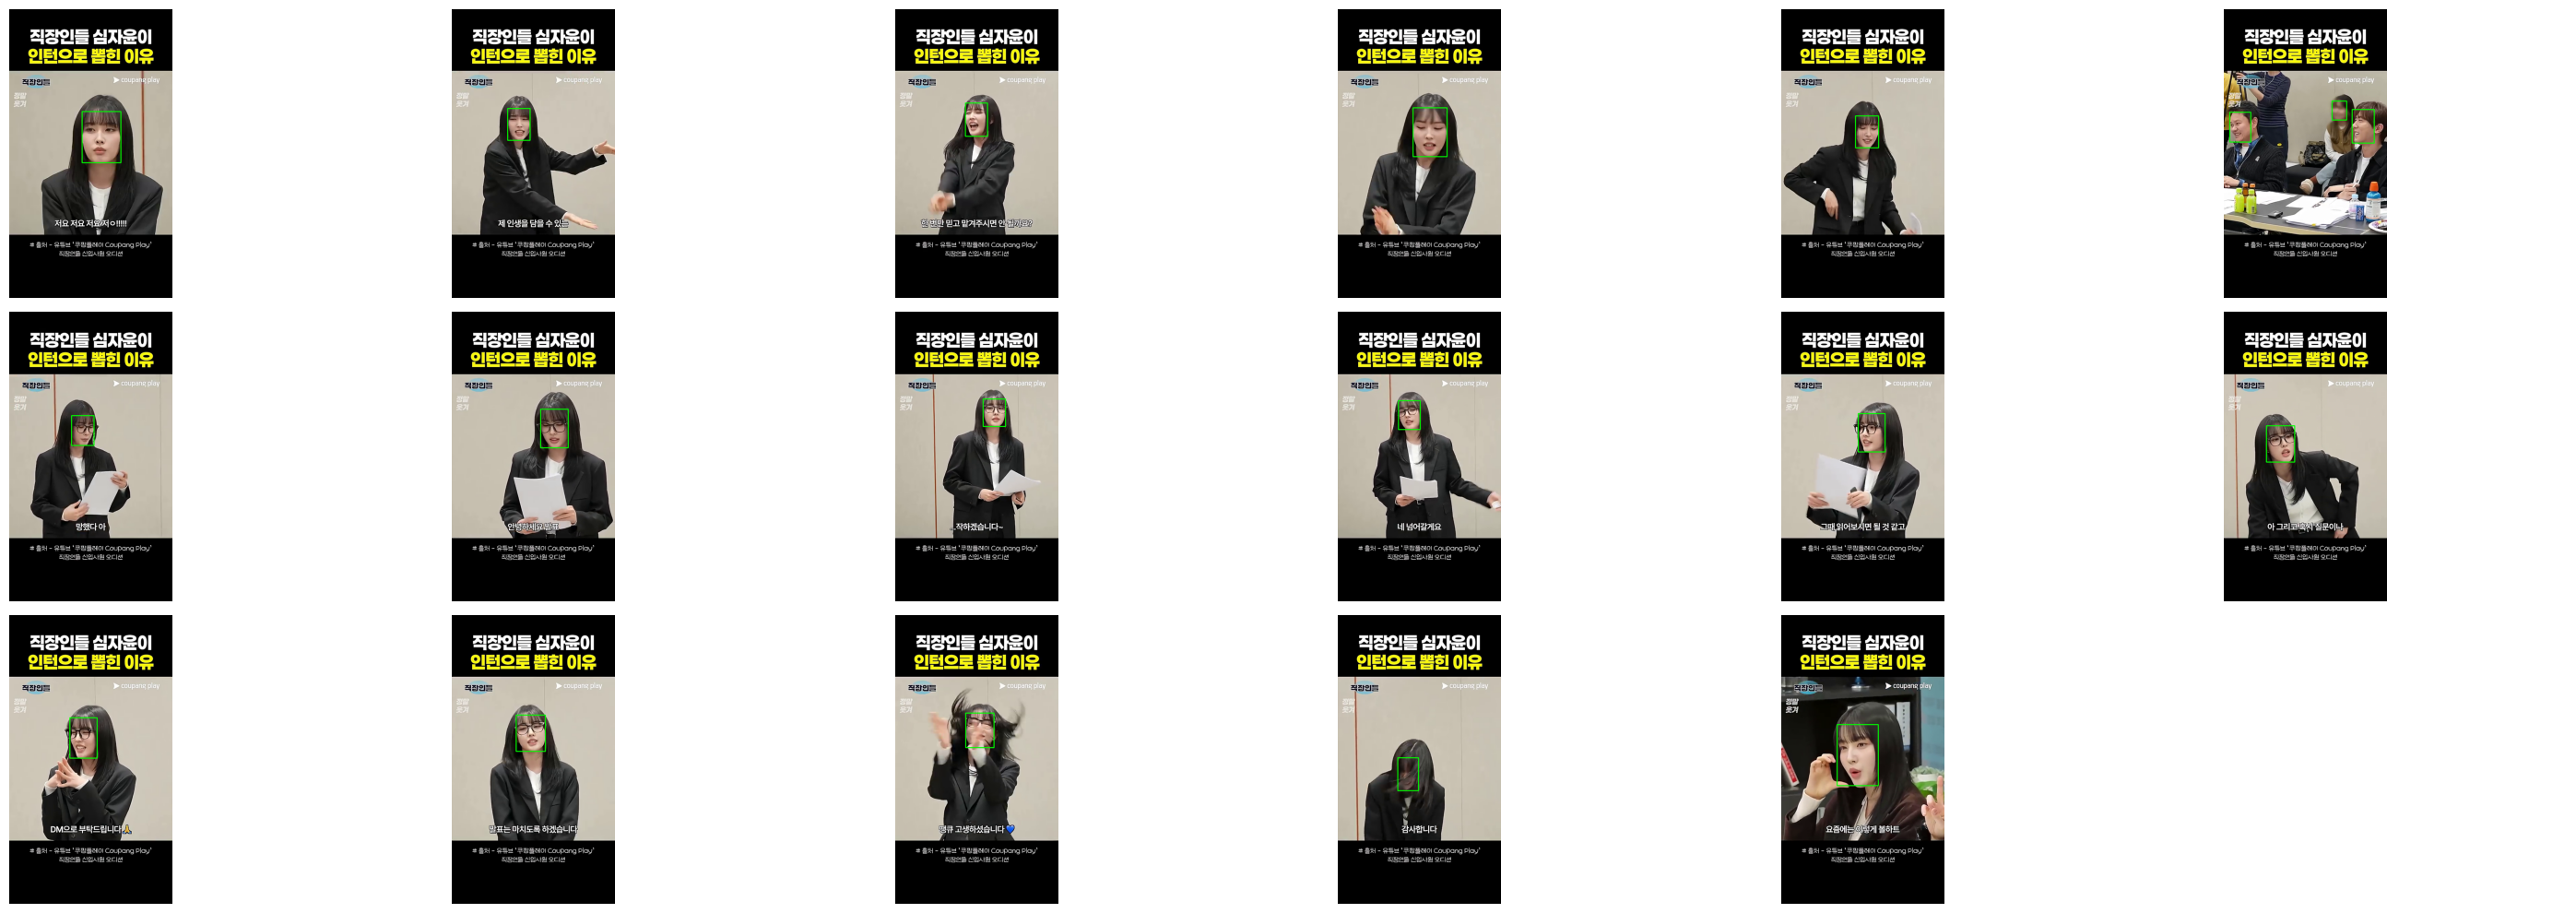

In [ ]:
import matplotlib.pyplot as plt

# 2행 6열 서브플롯 생성
fig, axes = plt.subplots(3, 6, figsize=(30, 10))

# result 리스트의 이미지를 서브플롯에 표시
for i, ax in enumerate(axes.flat):
    if i < len(result):
        ax.imshow(cv2.cvtColor(result[i], cv2.COLOR_BGR2RGB))  # BGR을 RGB로 변환
    ax.axis('off')  # 축 숨기기

plt.tight_layout()
plt.show()

# YOLOv12-Face로 faceDetect

In [ ]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.2 MB/s eta 0:00:00


In [ ]:
# YOLO 가중치 파일
# 구드 링크: https://drive.google.com/file/d/1ZpmtGC27LH4gUMHsDEw4eMYBb4csL3o7/view?usp=sharing
file_id = '1ZpmtGC27LH4gUMHsDEw4eMYBb4csL3o7'
!gdown {file_id} -O /content/yolov12-face.zip
!unzip /content/yolov12-face.zip -d /content/yolov12-face

Downloading...
From (original): https://drive.google.com/uc?id=1ZpmtGC27LH4gUMHsDEw4eMYBb4csL3o7
From (redirected): https://drive.google.com/uc?id=1ZpmtGC27LH4gUMHsDEw4eMYBb4csL3o7&confirm=t&uuid=88cc95b8-94de-4b2d-946a-2ccf67d03d16
To: /content/yolov12-face.zip
100% 109M/109M [00:01<00:00, 58.2MB/s] 
Archive:  /content/yolov12-face.zip
  inflating: /content/yolov12-face/yolov12n-face.pt  
  inflating: /content/yolov12-face/yolov12l-face.pt  
  inflating: /content/yolov12-face/yolov12m-face.pt  
  inflating: /content/yolov12-face/yolov12s-face.pt  


In [ ]:
import cv2
from ultralytics import YOLO

# YOLOv8 모델 로드 (얼굴 탐지용 사전 학습된 모델)
model = YOLO('/content/yolov12-face/yolov12l-face.pt')  # 얼굴 탐지용 YOLO 모델 파일

# 비디오 캡처 열기
cap = cv2.VideoCapture(test_vid)  # 비디오 파일 경로

# 결과를 저장할 리스트
result_frames = []
frame_count = 0
time_st = time.time()

# 얼굴 탐지 및 분석
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    if frame_count % 100 == 0:
        # YOLOv8을 사용하여 얼굴 탐지
        results = model(frame, verbose=False)

        # 감지된 얼굴에 바운딩 박스 그리기
        for result in results:
            boxes = result.boxes  # 바운딩 박스 정보
            for box in boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])  # 바운딩 박스 좌표
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

            # 감지된 이미지를 result_frames 리스트에 추가
            result_frames.append(frame)

    frame_count += 1

# 비디오 캡처 해제
cap.release()
time_end = time.time()
runtime = time_end - time_st
print(f'실행시간 {runtime:.2f}sec')

실행시간 2.93sec


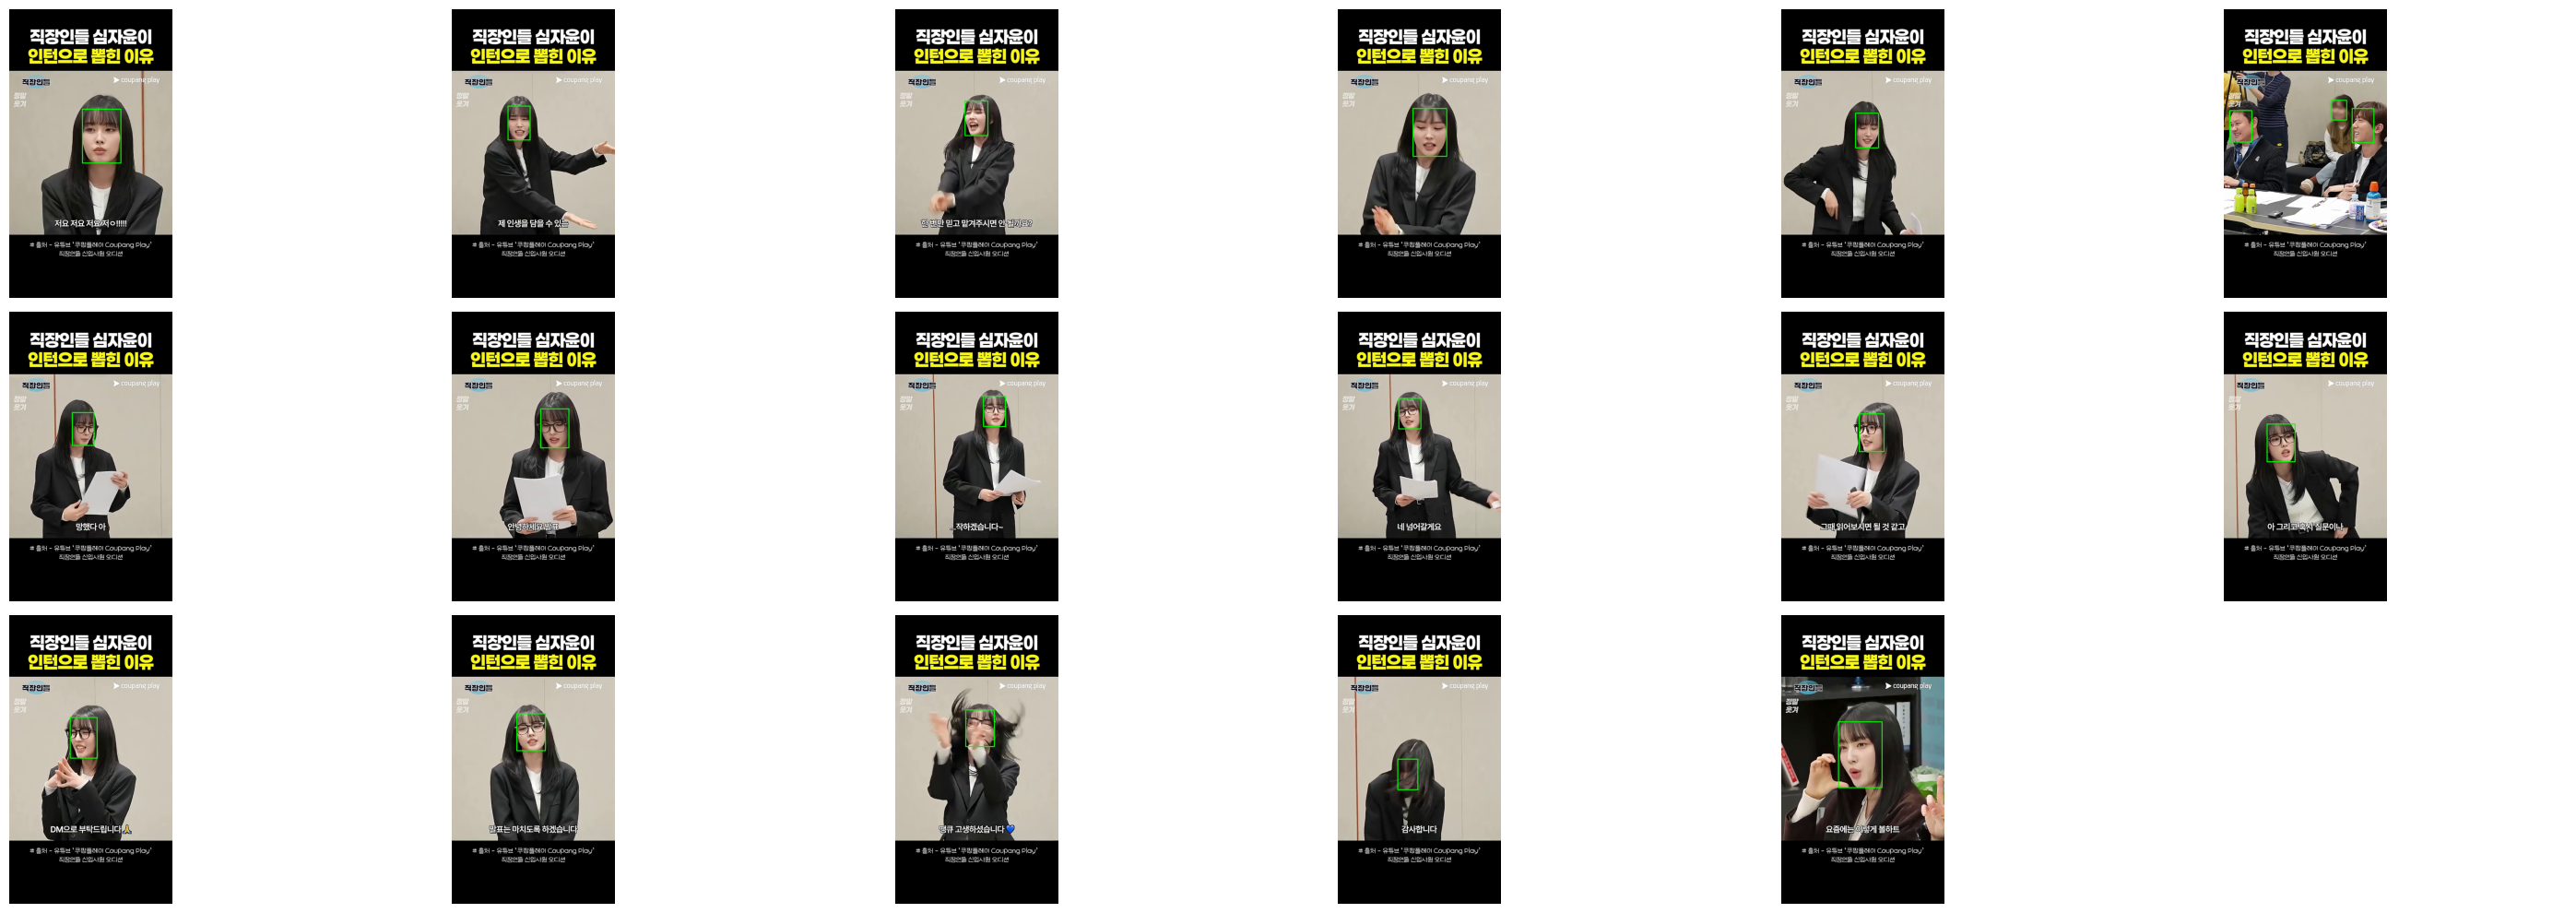

In [ ]:
import matplotlib.pyplot as plt

# 2행 6열 서브플롯 생성
fig, axes = plt.subplots(3, 6, figsize=(30, 10))

# result 리스트의 이미지를 서브플롯에 표시
for i, ax in enumerate(axes.flat):
    if i < len(result_frames):
        ax.imshow(cv2.cvtColor(result_frames[i], cv2.COLOR_BGR2RGB))  # BGR을 RGB로 변환
    ax.axis('off')  # 축 숨기기

plt.tight_layout()
plt.show()